We will be comparing Torch and Tensorflow to find unknown parameter phi given data x and function values f(x). Yes, using stochastic gradient descent for this is an overkill and analytical solution may be found easily, but this problem will serve our purpose well as a simple example.



In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch


First, let's create a simple SGD approximator for $f(x) = x^{exp}$, where $exp$ is a model parameter.



In [2]:
import torch
from torch.autograd import Variable
import numpy as np

def rmse(y, y_hat):
    """Compute root mean squared error"""
    return torch.sqrt(torch.mean((y - y_hat).pow(2).sum()))

def forward(x, e):
    """Forward pass for our fuction"""
    return x.pow(e.repeat(x.size(0)))

# Let's define some settings
n = 100 # number of examples
learning_rate = 5e-6

# Model definition
x = Variable(torch.rand(n) * 10, requires_grad=False)

# Model parameter and it's true value
exp = Variable(torch.FloatTensor([2.0]), requires_grad=False)
exp_hat = Variable(torch.FloatTensor([4]), requires_grad=True)
y = forward(x, exp)

loss_history = []
exp_history = []

# Training loop
for i in range(0, 200):
    print("Iteration %d" % i)
    
    # Compute current estimate
    y_hat = forward(x, exp_hat)
    
    # Calculate loss function
    loss = rmse(y, y_hat)
    
    # Do some recordings for plots
    loss_history.append(loss.data[0])
    exp_history.append(y_hat.data[0])
    
    # Compute gradients
    loss.backward()
    
    print("loss = %s" % loss.data[0])
    print("exp = %s" % exp_hat.data[0])
    
    # Update model parameters
    exp_hat.data -= learning_rate * exp_hat.grad.data
    exp_hat.grad.data.zero_()

Iteration 0
loss = 35755.71875
exp = 4.0
Iteration 1
loss = 14870.884765625
exp = 3.605100631713867
Iteration 2
loss = 10217.7919921875
exp = 3.438533067703247
Iteration 3
loss = 7844.7587890625
exp = 3.322671890258789
Iteration 4
loss = 6371.94775390625
exp = 3.2326266765594482
Iteration 5
loss = 5359.0703125
exp = 3.158583879470825
Iteration 6
loss = 4615.99072265625
exp = 3.095534324645996
Iteration 7
loss = 4045.826171875
exp = 3.0405426025390625
Iteration 8
loss = 3593.5947265625
exp = 2.9917287826538086
Iteration 9
loss = 3225.615966796875
exp = 2.9478116035461426
Iteration 10
loss = 2920.03466796875
exp = 2.9078760147094727
Iteration 11
loss = 2662.020751953125
exp = 2.8712451457977295
Iteration 12
loss = 2441.134765625
exp = 2.837402820587158
Iteration 13
loss = 2249.80859375
exp = 2.8059465885162354
Iteration 14
loss = 2082.416259765625
exp = 2.7765562534332275
Iteration 15
loss = 1934.6829833984375
exp = 2.7489724159240723
Iteration 16
loss = 1803.30322265625
exp = 2.72298240

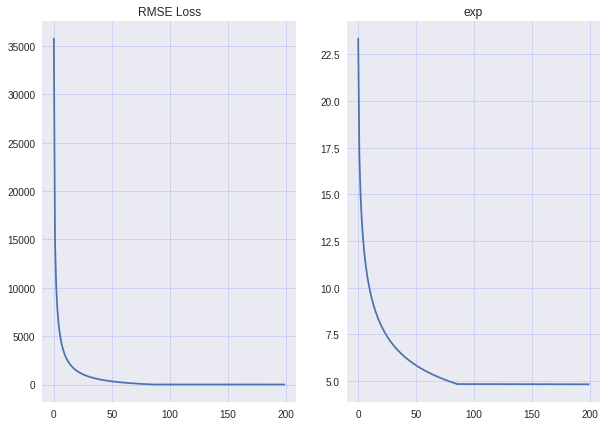

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(loss_history, exp_history):
    fig = plt.figure(figsize=(10, 7))
    fig.add_axes()

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    for ax in [ax1, ax2]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
        ax.tick_params(direction='out', color='b', width='2')
        
    ax1.set_title('RMSE Loss')
    ax2.set_title('exp')
    ax1.plot(np.arange(len(loss_history)), loss_history)
    ax2.plot(np.arange(len(exp_history)), exp_history)
    
plot_results(loss_history, exp_history)

In [4]:
import tensorflow as tf

def rmse(y, y_hat):
    """Compute root mean squared error"""
    return tf.sqrt(tf.reduce_mean(tf.square((y - y_hat))))

def forward(x, e):
    """Forward pass for our fuction"""
    # tensorflow has automatic broadcasting 
    # so we do not need to reshape e manually
    return tf.pow(x, e) 

n = 100 # number of examples
learning_rate = 5e-6

# Placeholders for data
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

# Model parameters
exp = tf.constant(2.0)
exp_hat = tf.Variable(4.0, name='exp_hat')

# Model definition
y_hat = forward(x, exp_hat)

# Optimizer
loss = rmse(y, y_hat)
opt = tf.train.GradientDescentOptimizer(learning_rate)

# We will run this operation to perform a single training step,
# e.g. opt.step() in Pytorch.
# Execution of this operation will also update model parameters
train_op = opt.minimize(loss) 

# Let's generate some training data
x_train = np.random.rand(n) + 10
y_train = x_train ** 2

loss_history = []
exp_history = []

# First, we need to create a Tensorflow session object
with tf.Session() as sess:
    
    # Initialize all defined variables
    tf.global_variables_initializer().run()
    
    # Training loop
    for i in range(0, 500):
        print("Iteration %d" % i)
        # Run a single trainig step
        curr_loss, curr_exp, _ = sess.run([loss, exp_hat, train_op], feed_dict={x: x_train, y: y_train})
        
        print("loss = %s" % curr_loss)
        print("exp = %s" % curr_exp)
        
        # Do some recordings for plots
        loss_history.append(curr_loss)
        exp_history.append(curr_exp)

Iteration 0
loss = 12119.081
exp = 4.0
Iteration 1
loss = 8601.072
exp = 3.8559773
Iteration 2
loss = 6731.37
exp = 3.7533932
Iteration 3
loss = 5549.04
exp = 3.6728308
Iteration 4
loss = 4727.121
exp = 3.6061933
Iteration 5
loss = 4119.929
exp = 3.5492358
Iteration 6
loss = 3651.7817
exp = 3.499429
Iteration 7
loss = 3279.1702
exp = 3.4551353
Iteration 8
loss = 2975.1853
exp = 3.4152296
Iteration 9
loss = 2722.2444
exp = 3.3789036
Iteration 10
loss = 2508.3438
exp = 3.3455563
Iteration 11
loss = 2324.998
exp = 3.3147275
Iteration 12
loss = 2166.0337
exp = 3.2860577
Iteration 13
loss = 2026.8455
exp = 3.2592597
Iteration 14
loss = 1903.927
exp = 3.2341006
Iteration 15
loss = 1794.5603
exp = 3.210389
Iteration 16
loss = 1696.6025
exp = 3.187965
Iteration 17
loss = 1608.3442
exp = 3.1666944
Iteration 18
loss = 1528.4026
exp = 3.1464632
Iteration 19
loss = 1455.6455
exp = 3.127173
Iteration 20
loss = 1389.1404
exp = 3.1087394
Iteration 21
loss = 1328.1101
exp = 3.091089
Iteration 22
loss 

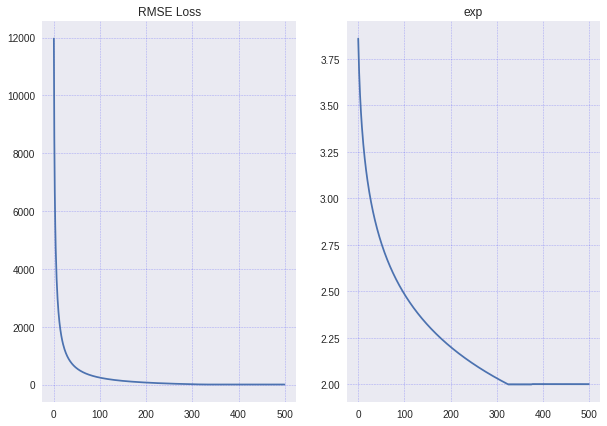

In [5]:
plot_results(loss_history, exp_history)
